In [76]:
import argparse
import torch
from path import Path
from torch.utils.data import DataLoader
from model.VAE import VAEAnomalyTabular
from vae_dataset import VAEDataset, VAEwLabels
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--input-size', '-i', type=int, default=5, dest='input_size', help='Number of input features. In 1D case it is the vector length, in 2D case it is the number of channels')
parser.add_argument('--latent-size', '-l', type=int, default=2, dest='latent_size', help='Size of the latent space')
parser.add_argument('--hidden-1', '-h1', type=int, default=300, dest='hidden_1', help='Size of hidden layer 1 in encoder and decoder')
parser.add_argument('--hidden-2', '-h2', type=int, default=100, dest='hidden_2', help='Size of hidden layer 2 in encoder and decoder')
parser.add_argument('--num-resamples', '-L', type=int, dest='num_resamples', default=10,
                    help='Number of resamples in the latent distribution during training')
parser.add_argument('--epochs', '-e', type=int, dest='epochs', default=20, help='Number of epochs to train for')
parser.add_argument('--batch-size', '-b', type=int, dest='batch_size', default=32)
parser.add_argument('--device', '-d', '--accelerator', type=str, dest='device', default='gpu', help='Device to use for training. Can be cpu, gpu or tpu', choices=['cpu', 'gpu', 'tpu'])
parser.add_argument('--lr', type=float, dest='lr', default=1e-3, help='Learning rate')
parser.add_argument('--no-progress-bar', action='store_true', dest='no_progress_bar')
parser.add_argument('--steps-log-loss', type=int, dest='steps_log_loss', default=1_000, help='Number of steps between each loss logging')
parser.add_argument('--steps-log-norm-params', type=int, 
                    dest='steps_log_norm_params', default=1_000, help='Number of steps between each model parameters logging')

args = parser.parse_args('')

In [3]:
# Generate reconstruction probabilities with default alpha of test set
# (probability "cut-off", in contrast with "threshold", i.e. 1 - threshold = alpha)

df = pd.read_csv("data/HI_Small_Trans_ordinal_test_vae-.csv")
dataset = df.drop(columns=['Is Laundering'])

test_set = VAEDataset(dataset.reset_index(drop=True))
test_dloader = DataLoader(test_set, args.batch_size, shuffle=False)

checkpointfile = torch.load(
    'C:\\YKT\\NUS_MComp\\CS5340_project\\comp5340\\lightning_logs\\version_81\\checkpoints\\last.ckpt')
net = VAEAnomalyTabular(args.input_size, args.latent_size, args.hidden_1, args.hidden_2, args.num_resamples, lr=args.lr)
net.load_state_dict(checkpointfile["state_dict"])
net.eval()

y_pred = []
y_prob = []

y_true = df["Is Laundering"]
for batch in test_dloader:
    #print("Test set (class 0)")
    with torch.no_grad():
        #print(net.is_anomaly(batch))
        prob, pred = net.is_anomaly(batch, alpha=0.05)
        prob, pred = prob.cpu().numpy(), pred.cpu().numpy()
        y_pred.extend(pred)
        y_prob.extend(prob)

print(confusion_matrix(y_true, y_pred))
print(f1_score(y_true, y_pred))

[[905423 162627]
 [   261    844]]
0.010256659537235077


In [4]:
# probability that x is fraudulent
y_prob = 1 - np.array(y_prob)
y_prob

array([0.87937766, 0.8992132 , 0.8970937 , ..., 0.8991315 , 0.9392209 ,
       0.96135485], dtype=float32)

In [5]:
def cal_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return {
        'accuracy': round(accuracy_score(y_test, y_pred), 4),
        #'f1_score_w': round(f1_score(y_test, y_pred, average='weighted'), 4),  # Or use 'macro', 'micro', or None for different averaging methods
        'f1_score_b': round(f1_score(y_test, y_pred, average='binary'), 4),    # Or use 'macro', 'micro', or None for different averaging methods
        'precision': round(precision_score(y_test, y_pred), 4),
        'recall': round(recall_score(y_test, y_pred), 4),
        'tp': tp,
        'fp': fp,
        'tpr': round(tp / (tp + fn), 4),
        'fpr': round(fp / (tn + fp), 4)
    }

for i in range(850, 1000, 5):
    threshold = i/10 / 100
    y_pred = np.where(y_prob >= threshold, 1, 0)
    metrics = {'threshold': threshold}
    metrics.update(cal_metrics(y_true, y_pred))
    print(metrics)

{'threshold': 0.85, 'accuracy': 0.0169, 'f1_score_b': 0.0021, 'precision': 0.0011, 'recall': 1.0, 'tp': 1105, 'fp': 1051116, 'tpr': 1.0, 'fpr': 0.9841}
{'threshold': 0.855, 'accuracy': 0.0886, 'f1_score_b': 0.0023, 'precision': 0.0011, 'recall': 0.9991, 'tp': 1104, 'fp': 974390, 'tpr': 0.9991, 'fpr': 0.9123}
{'threshold': 0.86, 'accuracy': 0.2194, 'f1_score_b': 0.0026, 'precision': 0.0013, 'recall': 0.9828, 'tp': 1086, 'fp': 834580, 'tpr': 0.9828, 'fpr': 0.7814}
{'threshold': 0.865, 'accuracy': 0.3541, 'f1_score_b': 0.003, 'precision': 0.0015, 'recall': 0.952, 'tp': 1052, 'fp': 690509, 'tpr': 0.952, 'fpr': 0.6465}
{'threshold': 0.87, 'accuracy': 0.4569, 'f1_score_b': 0.0035, 'precision': 0.0017, 'recall': 0.9158, 'tp': 1012, 'fp': 580517, 'tpr': 0.9158, 'fpr': 0.5435}
{'threshold': 0.875, 'accuracy': 0.5235, 'f1_score_b': 0.0039, 'precision': 0.002, 'recall': 0.9014, 'tp': 996, 'fp': 509353, 'tpr': 0.9014, 'fpr': 0.4769}
{'threshold': 0.88, 'accuracy': 0.5652, 'f1_score_b': 0.0042, 'pr

The choice for an appropriate threshold depends on the balanced requirements of having high TPR and low FPR.  
**Selected threshold = 0.945**

Threshold: 0.945
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1068050
           1       0.00      0.82      0.01      1105

    accuracy                           0.82   1069155
   macro avg       0.50      0.82      0.45   1069155
weighted avg       1.00      0.82      0.90   1069155

Confusion Matrix:
[[874213 193837]
 [   196    909]]

Metrics: {'threshold': 0.945, 'accuracy': 0.8185, 'f1_score_b': 0.0093, 'precision': 0.0047, 'recall': 0.8226, 'tp': 909, 'fp': 193837, 'tpr': 0.8226, 'fpr': 0.1815}


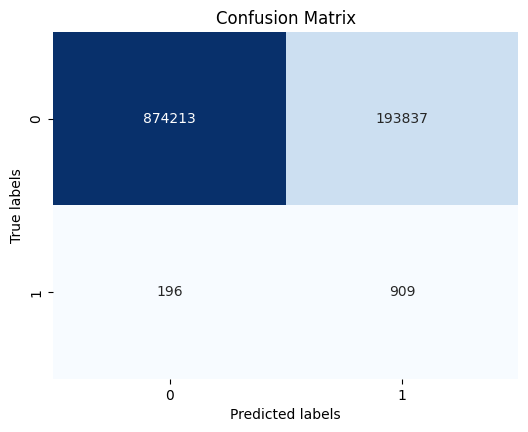

In [15]:
def plot_cm(metrics, y_test, y_pred, outfile=None):
    print("Metrics:", metrics)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # cm = confusion_matrix(y_pred, y_test)
    
    # Create a Matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 4.5))
    
    # Plot confusion matrix on the specified axis
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=[0, 1],
                yticklabels=[0, 1], ax=ax)
    for pos in []:
        plt.gca().add_patch(plt.Rectangle(pos, 1, 1, fill=True, color='red', alpha=0.1))  # , edgecolor='red', lw=3))
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.title(f"Confusion Matrix")
    if outfile is not None:
        plt.savefig(outfile)
    plt.show()
    plt.close()

threshold = 0.945
y_pred = np.where(y_prob >= threshold, 1, 0)

# Evaluate performance with adjusted labels
print("Threshold:", threshold)
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print()

metrics = {'threshold': threshold}
metrics.update(cal_metrics(y_true, y_pred))
plot_cm(metrics, y_true, y_pred, outfile="./data/vae_cm.png")

In [77]:
# For plotting AUROC
FPR_list, TPR_list, threshold = roc_curve(y_true, y_prob, drop_intermediate=False)

In [62]:
# Read predicted probabilities for other methods for plotting
bayeslog1 = pd.read_csv("./data/bayesian_logistic_regression_model1_predict.csv")
bayeslog2 = pd.read_csv("./data/bayesian_logistic_regression_model2_predict.csv")
naivebayes = pd.read_csv("./data/HI_Small_Trans_Naive_Bayes_Proba-2.csv")
hmm = pd.read_csv("./data/hmm_score.csv")
gmm = pd.read_csv("./data/gmm3_roc_auc.csv")


In [78]:
bayeslog1FPR_list, bayeslog1TPR_list, bayeslog1threshold = roc_curve(bayeslog1.iloc[:,0], bayeslog1.iloc[:,1], drop_intermediate=False)
bayeslog2FPR_list, bayeslog2TPR_list, bayeslog2threshold = roc_curve(bayeslog2.iloc[:,0], bayeslog2.iloc[:,1], drop_intermediate=False)
nbFPR_list, nbTPR_list, nbthreshold = roc_curve(naivebayes.iloc[:,0].astype(int), naivebayes.iloc[:,1], drop_intermediate=False)
hmmFPR_list, hmmTPR_list, hmmthreshold = roc_curve(hmm.iloc[:,1], hmm.iloc[:,0], drop_intermediate=False)
gmmFPR_list, gmmTPR_list, gmmthreshold = roc_curve(gmm.iloc[:,0], gmm.iloc[:,1], drop_intermediate=False)

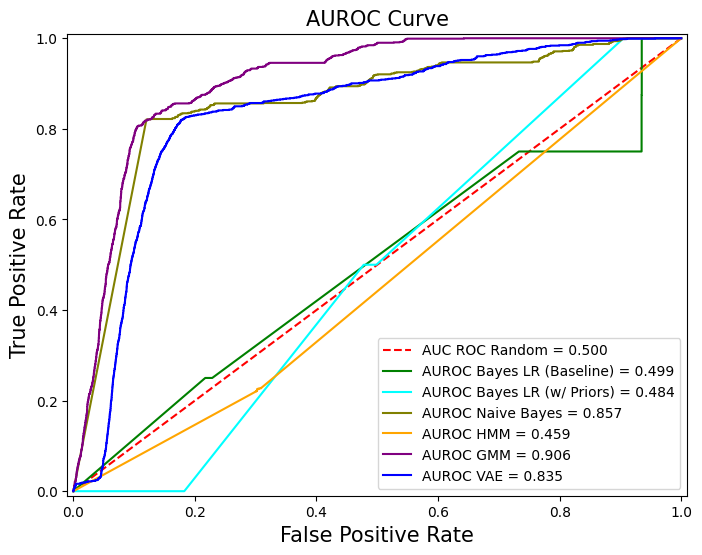

In [103]:
# Plot combined AUROC curves

def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.500")

ROC_AUC = auc(FPR_list, TPR_list)
ROC_AUC_bayes1 = auc(bayeslog1FPR_list, bayeslog1TPR_list)
ROC_AUC_bayes2 = auc(bayeslog2FPR_list, bayeslog2TPR_list)
ROC_AUC_nb = auc(nbFPR_list, nbTPR_list)
ROC_AUC_hmm = auc(hmmFPR_list, hmmTPR_list)
ROC_AUC_gmm = auc(gmmFPR_list, gmmTPR_list)
    
roc_curve, ax = plt.subplots(figsize=(8,6))
get_template_roc_curve(ax, "AUROC Curve",fs=15)
ax.plot(bayeslog1FPR_list, bayeslog1TPR_list, color='green', label = 'AUROC Bayes LR (Baseline) = {0:0.3f}'.format(ROC_AUC_bayes1))
ax.plot(bayeslog2FPR_list, bayeslog2TPR_list, color='cyan', label = 'AUROC Bayes LR (w/ Priors) = {0:0.3f}'.format(ROC_AUC_bayes2))
ax.plot(nbFPR_list, nbTPR_list, color='olive', label = 'AUROC Naive Bayes = {0:0.3f}'.format(ROC_AUC_nb))
ax.plot(hmmFPR_list, hmmTPR_list, color='orange', label = 'AUROC HMM = {0:0.3f}'.format(ROC_AUC_hmm))
ax.plot(gmmFPR_list, gmmTPR_list, color='purple', label = 'AUROC GMM = {0:0.3f}'.format(ROC_AUC_gmm))
ax.plot(FPR_list, TPR_list, color='blue', label = 'AUROC VAE = {0:0.3f}'.format(ROC_AUC))
ax.legend(loc = 'lower right')

In [11]:
# Visualize latent space of test set

df = pd.read_csv("data/HI_Small_Trans_ordinal_test_vae-.csv")

test_set = VAEwLabels(df.reset_index(drop=True))
test_dloader = DataLoader(test_set, args.batch_size, shuffle=True)

# checkpointfile = torch.load(
#     'C:\\YKT\\NUS_MComp\\CS5340_project\\comp5340\\lightning_logs\\version_81\\checkpoints\\last.ckpt')
# net = VAEAnomalyTabular(args.input_size, args.latent_size, args.hidden_1, args.hidden_2, args.num_resamples, lr=args.lr)
# net.load_state_dict(checkpointfile["state_dict"])
# net.eval()

encoded = []
enc_labels = []
# collect samples each for positive and negative class
sample_count_pos = 0
sample_count_neg = 0
for batch in test_dloader:
    for i in range(len(batch)):
        if (batch[1][i].item() == 1) and (sample_count_pos < 1000):
            with torch.no_grad():
                encoded.append(net.encoder(batch[0][i]).squeeze(0).detach().cpu())
            enc_labels.append(1)
            sample_count_pos += 1
        elif (batch[1][i].item() == 0) and (sample_count_neg < 10000):
            with torch.no_grad():
                encoded.append(net.encoder(batch[0][i]).squeeze(0).detach().cpu())
            enc_labels.append(0)
            sample_count_neg += 1

    if sample_count_pos + sample_count_neg >= 11000: break

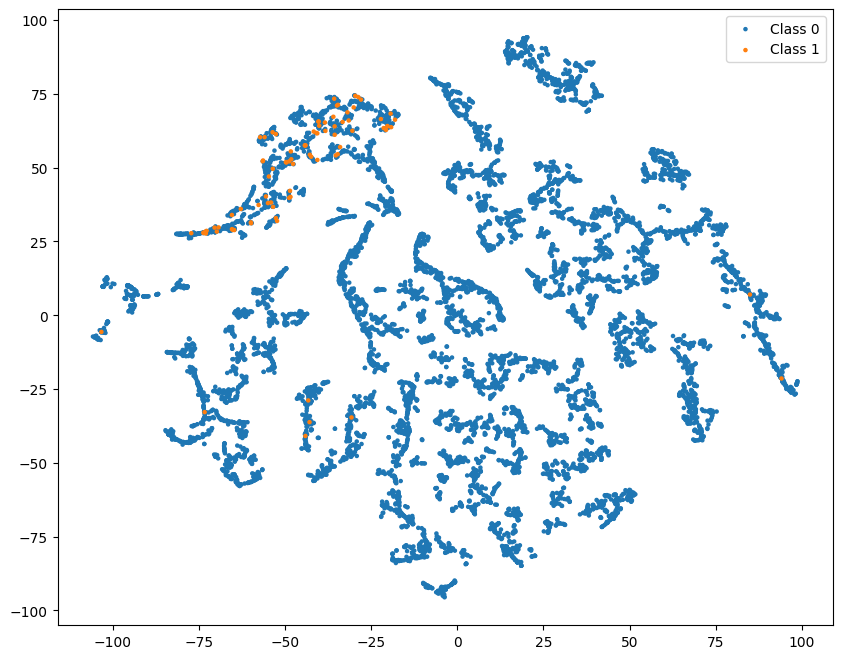

In [12]:
# Visualize latent space of test set

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(np.array(encoded))

enc_labels = np.array(enc_labels)

unique_labels = np.arange(2)

colors = plt.cm.tab10(enc_labels)

# Sort labels and corresponding colors
sorted_indices = np.argsort(enc_labels)
sorted_labels = enc_labels[sorted_indices]
sorted_colors = colors[sorted_indices]
sorted_tsne = tsne_results[sorted_indices]

plt.figure(figsize=(10,8))

for i in unique_labels:
    indices = np.where(sorted_labels == i)
    plt.scatter(sorted_tsne[indices, 0], sorted_tsne[indices, 1], color=sorted_colors[indices], label=f"Class {i}", s=5)

plt.legend()
plt.show()

In [13]:
# Visualize latent space of train set

df = pd.read_csv("data/HI_Small_Trans_ordinal_train_vae-.csv")

test_set = VAEwLabels(df.reset_index(drop=True))
test_dloader = DataLoader(test_set, args.batch_size, shuffle=True)

# checkpointfile = torch.load(
#     'C:\\YKT\\NUS_MComp\\CS5340_project\\comp5340\\lightning_logs\\version_81\\checkpoints\\last.ckpt')
# net = VAEAnomalyTabular(args.input_size, args.latent_size, args.hidden_1, args.hidden_2, args.num_resamples, lr=args.lr)
# net.load_state_dict(checkpointfile["state_dict"])
# net.eval()

encoded = []
enc_labels = []
# collect samples each for positive and negative class
sample_count_pos = 0
sample_count_neg = 0
for batch in test_dloader:
    for i in range(len(batch)):
        if (batch[1][i].item() == 1) and (sample_count_pos < 4000):
            with torch.no_grad():
                encoded.append(net.encoder(batch[0][i]).squeeze(0).detach().cpu())
            enc_labels.append(1)
            sample_count_pos += 1
        elif (batch[1][i].item() == 0) and (sample_count_neg < 40000):
            with torch.no_grad():
                encoded.append(net.encoder(batch[0][i]).squeeze(0).detach().cpu())
            enc_labels.append(0)
            sample_count_neg += 1
    if sample_count_pos + sample_count_neg >= 44000: break

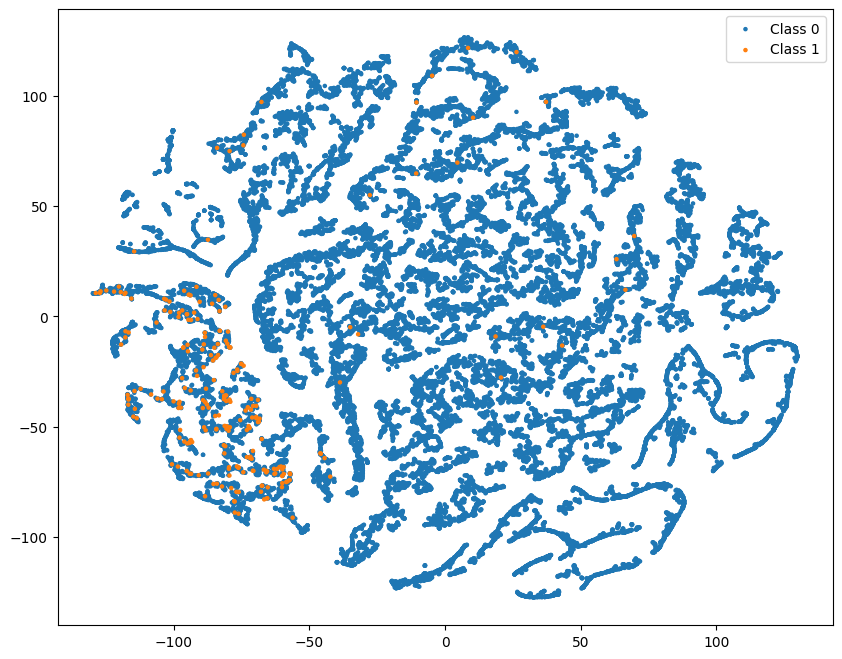

In [14]:
# # Visualize latent space of train set

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(np.array(encoded))

enc_labels = np.array(enc_labels)

unique_labels = np.arange(2)

colors = plt.cm.tab10(enc_labels)

# Sort labels and corresponding colors
sorted_indices = np.argsort(enc_labels)
sorted_labels = enc_labels[sorted_indices]
sorted_colors = colors[sorted_indices]
sorted_tsne = tsne_results[sorted_indices]

plt.figure(figsize=(10,8))

for i in unique_labels:
    indices = np.where(sorted_labels == i)
    plt.scatter(sorted_tsne[indices, 0], sorted_tsne[indices, 1], color=sorted_colors[indices], label=f"Class {i}", s=5)

plt.legend()
plt.show()